In [1]:
import fenics as fn
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from dolfin_utils.meshconvert import meshconvert
import os
from subprocess import call
import datetime
import dolfin

import ffc.log
ffc.log.set_level(ffc.log.ERROR)
fn.set_log_active(False)


In [2]:
def curl2D(v):
    return as_vector((v.dx(1),-v.dx(0)))

class FEM():
            
    def __init__(self, Nt = 24, I0 = 45, mu0=4*np.pi*1e-7, mur=1500, meshsize = 0.002, params = [0,0,0,0], verb = False):
        path='./'
        tme1 = datetime.datetime.now()
        with open(path + 'quad_proto.geo', 'r') as file:
            data = file.read()
            
        s = "params0 = %.18f;\n params1 = %.18f;\n params2 = %.18f;\n params3 = %.18f;\n  meshsize=%.18f;\n"%(params[0],params[1],params[2],params[3],meshsize)
        
        s = s + data
        
        with  open(path+"tmp.geo", "w") as file:
            file.write(s)
            file.close()
        if verb: print('geo file created',flush = True)
        
        if verb:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 '%(path,path))
        else:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 >/dev/null 2>&1'%(path,path))
        if verb: print('mesh file created',flush=True)

        if verb:
            os.system('dolfin-convert %stmp.msh %stmp.xml'%(path,path))
        else:
            os.system('dolfin-convert %stmp.msh %stmp.xml >/dev/null 2>&1'%(path,path))
        
        if verb: print('mesh file converted in fenics format',flush=True) 

        mesh = fn.Mesh(path+'tmp.xml')
        domains = fn.MeshFunction("size_t", mesh, path+'tmp_physical_region.xml')
        boundaries = fn.MeshFunction('size_t', mesh, path+'tmp_facet_region.xml')

        ncells = [  mesh.num_vertices(), mesh.num_edges(), mesh.num_faces(), mesh.num_facets(), mesh.num_cells() ]
        
        def nu_lin(az):
            return 1/(mu0*mur)
        
        
       
        
        
        mesh = Mesh(path +"tmp.xml")
        boundaries = MeshFunction("size_t", mesh, path + "tmp_facet_region.xml")
        domains    = MeshFunction("size_t", mesh, path + "tmp_physical_region.xml")
        ncells = [  mesh.num_vertices(), mesh.num_edges(), mesh.num_faces(), mesh.num_facets(), mesh.num_cells() ]
        self.mesh = mesh



        
        
        """ define function space and boundary conditions"""
        
        CG = FunctionSpace(mesh, 'CG', 1) # Continuous Galerkin
        self.dim = CG.dim() 
        # Define boundary condition
        bc = DirichletBC(CG, Constant(0.0), boundaries,16)
        
        # Define subdomain markers and integration measure
        dx = Measure('dx', domain=mesh, subdomain_data=domains)
        
        area_cu = assemble(Constant(1.0)*dx(19))
 
        # Coil
        def setup_coil(mesh,subdomains,J0):
            DG = FunctionSpace(mesh,"DG",0)
            J = Function(DG)
            idx = []
            for cell_no in range(len(subdomains.array())):
                subdomain_no = subdomains.array()[cell_no]
                if subdomain_no == 19:
                    idx.append(cell_no)
            J.vector()[:] = 0
            J.vector()[idx] = J0
            return J

        self.current =  I0*Nt/area_cu
        J = setup_coil(mesh, domains, self.current)
        
        class Nu(UserExpression): # UserExpression instead of Expression
            def __init__(self, markers, **kwargs):
                super().__init__(**kwargs) # This part is new!
                self.markers = markers
                self.value_shape = lambda x: None
            def eval_cell(self, values, x, cell):
                if self.markers[cell.index] == 17:
                    values[0] = 1/(mu0*mur)   # iron
                elif self.markers[cell.index] == 18:
                    values[0] = 1/mu0      # air
                elif self.markers[cell.index] == 19:
                    values[0] = 1/mu0      # air
                else:
                    print('no such domain',self.markers[cell.index] )
                    
        nus = Nu(domains, degree=1)
        
        
        """ weak formulation """
        
        az  = Function(CG)
        u  = Function(CG)
        v  = TestFunction(CG)
        #az = Function(CG)
        #a  = (1/mu)*dot(grad(az), grad(v))*dx
        a = inner(nus*curl2D(u), curl2D(v))*dx #+ inner(nu_lin(curl2D(u))*curl2D(u),curl2D(v))*dx(1)
        L  = J*v*dx(19)
        
        F = a - L
        tme1 = datetime.datetime.now()-tme1
        if verb: print('Meshing+assembly time ',tme1)
        # solve variational problem
        tme = datetime.datetime.now()
        solve(F == 0, u, bc)
        tme = datetime.datetime.now() - tme
        if verb: print('Solver time',tme)
        az = u
        self.az = az
        # function space for H- and B- field allocated on faces of elements
        W = VectorFunctionSpace(mesh, FiniteElement("DP", triangle, 0),1)
        B = project(curl2D(az), W)
        H = None# project((1/mu)*curl(az), W)
        self.B = B
        self.H = H
        self.integral = assemble(u*dx)


    def call_A(self,x_eval,y_eval):
        
        
        Afem = 0 * x_eval
        for i in range(x_eval.size):
            try:
                Afem[i] = self.az(x_eval[i],y_eval[i])
            except:
                Afem[i] = np.nan
        return Afem
    
    def call_B(self,x_eval,y_eval):
        
        
        Bfem = []
        for i in range(x_eval.size):
            try:
                Bfem.append(self.B(x_eval[i],y_eval[i]))
            except:
                Bfem.append([ np.nan , np.nan])
        return np.array(Bfem)
    
    def call_H(self,x_eval,y_eval):
        Hfem = []
        for i in range(x_eval.size):
            try:
                Hfem.append(self.H(x_eval[i],y_eval[i]))
            except:
                Hfem.append([ np.nan , np.nan])
        return np.array(Hfem)

geo file created
Info    : Running '/home/yonnss/anaconda3/envs/fenics/bin/gmsh ./tmp.geo -nt 20 -3 -o ./tmp.msh -format msh2' [Gmsh 4.9.5, 1 node, max. 20 threads]
Info    : Started on Sat Sep 10 22:04:20 2022
Info    : Reading './tmp.geo'...
Info    : Done reading './tmp.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 9 (Line)
Info    : [  0%] Meshing curve 4 (Line)
Info    : [  0%] Meshing curve 2 (Line)
Info    : [  0%] Meshing curve 10 (Line)
Info    : [  0%] Meshing curve 3 (Line)
Info    : [  0%] Meshing curve 13 (Line)
Info    : [  0%] Meshing curve 12 (Line)
Info    : [  0%] Meshing curve 1 (Line)
Info    : [  0%] Meshing curve 8 (Line)
Info    : [  0%] Meshing curve 7 (Line)
Info    : [  0%] Meshing curve 11 (Line)
Info    : [  0%] Meshing curve 14 (Ellipse)
Info    : [  0%] Meshing curve 6 (Line)
Info    : [  0%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00482192s, CPU 0.058498s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Surface, 

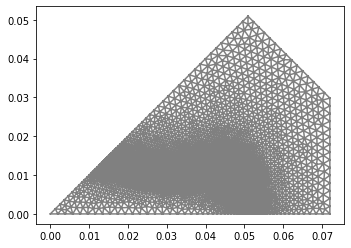

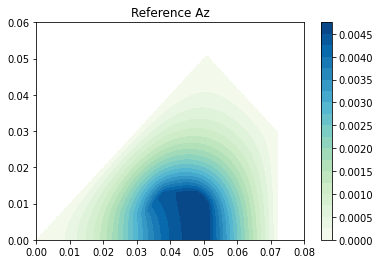

In [3]:
x_mesh, y_mesh = np.meshgrid(np.linspace(0,0.08,200),np.linspace(0,0.06,200))

fem = FEM(verb=True)

plt.figure()
fn.plot(fem.mesh)

A_ref = fem.call_A(x_mesh.flatten(),y_mesh.flatten()).reshape(x_mesh.shape)




plt.figure()
plt.contourf(x_mesh,y_mesh,A_ref,levels=20,cmap = 'GnBu')
plt.colorbar()
plt.title('Reference Az')


print('DoFs ', fem.dim)


In [4]:
import pickle

with open('quad_parameters3.pkl','rb') as f:
    data = pickle.load(f)

Theta [-4.50643406e-04  6.18192081e-04  6.72183615e-05  5.41930496e-04]
Error L2 relative 0.000907914257656816
Error max relative 0.006075008913829638
Integral FEM  3.6748474379472666e-06  IGA 3.677682543506816e-06
4918233.137201781 4918233.137201784


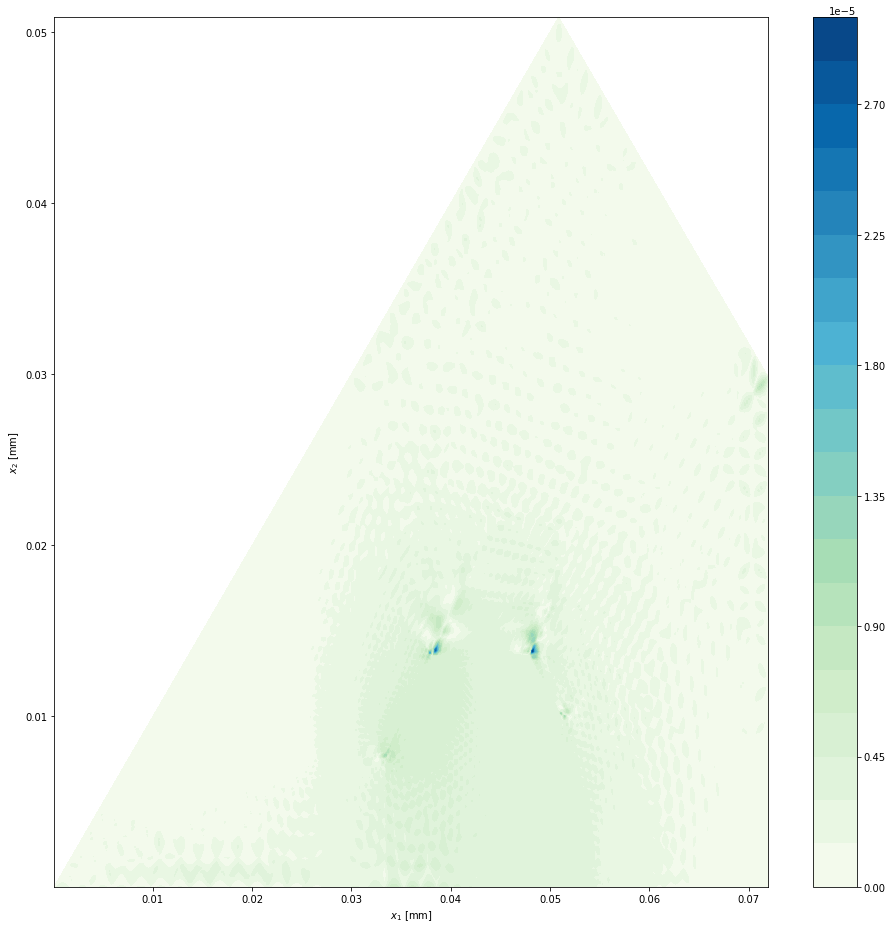

In [5]:

x1, x2 = data[2]['x1'], data[2]['x2']
A = data[2]['A']
ws = data[2]['w']

fem = FEM(params=data[2]['thetas'], meshsize = 0.002)
A_ref = fem.call_A(x1.flatten(),x2.flatten()).reshape(x1.shape)

plt.figure(figsize=(16,16))
plt.contourf(x1,x2,np.abs(A-A_ref),levels = 20, cmap = 'GnBu')
plt.xlabel(r'$x_1$ [mm]')
plt.ylabel(r'$x_2$ [mm]')
plt.colorbar()

print('Theta', data[2]['thetas'])
print('Error L2 relative',np.sum(np.abs(A-A_ref)*ws)/np.sum(A*ws))
print('Error max relative',np.max(np.abs(A-A_ref))/np.max(A))
print('Integral FEM ', fem.integral,' IGA', np.sum(A*ws) )
print(fem.current, data[2]['J0'])


In [6]:
errz = []
errz_max = []
meshsize = 0.002

for i in range(len(data)):
    print(i)
    A = data[i]['A']
    ws = data[i]['w']
 
    fem = FEM(params=data[i]['thetas'], meshsize=meshsize)
    
    A_ref = fem.call_A(data[i]['x1'].flatten(),data[i]['x2'].flatten()).reshape(x1.shape)

    errz.append(np.sum(np.abs(A-A_ref)*ws)/np.sum(A*ws))
    errz_max.append(np.max(np.abs(A-A_ref)))

print(errz_max)
print(errz)

print(np.max(errz_max))
print(np.max(errz))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
[2.866917012264887e-05, 2.450356599925825e-05, 2.9727668950661583e-05, 3.0228277518317553e-05, 2.847700211585768e-05, 2.2872328704269702e-05, 3.291761591481517e-05, 2.7677466864379878e-05, 2.861966770328992e-05, 3.0955964011811395e-05, 3.375614619867233e-05, 2.859895774801058e-05, 2.8704204577594504e-05, 3.4133453820578766e-05, 3.347948181783595e-05, 3.4934901596366495e-05, 2.574799067825255e-05, 2.3062699307711473e-05, 3.090437284837197e-05, 2.150109987133792e-05, 2.759395969668e-05, 2.360782754013812e-05, 3.157197528171063e-05, 3.296775612378518e-05, 2.8238475962563507e-05, 2.3506197770475738e-05, 3.321552513577911e-05, 2.704751333072481e-05, 3.077507249517157e-05, 3.6450125105382154e-05, 3.221825656250961e-05, 2.5260742751987558e-05]
[0.0008182324936619793, 0.0008375302207026751, 0.0009079142576375398, 0.0008781692887783565, 0.0008378782280228186, 0.0008312306865945715, 0.0008800425900772299, 0.000

In [7]:
s = ''
for meshsize in [0.008,0.004,0.002,0.001,0.0005,0.00025,0.000125]:
    errz = []
    errz_max =[]
    print(meshsize)
    for i in range(len(data)):
        print(i)
        A = data[i]['A']
        ws = data[i]['w']

        fem = FEM(params=data[i]['thetas'], meshsize=meshsize)
        
        A_ref = fem.call_A(data[i]['x1'].flatten(),data[i]['x2'].flatten()).reshape(data[i]['x2'].shape)

        err = np.sum(np.abs(A-A_ref)*ws)/np.sum(A*ws)
        err_max = np.max(np.abs(A-A_ref))
        errz.append(err)
        errz_max.append(err_max)
    s += '\n\nmeshsize %e, DoFs %d\n'%(meshsize,fem.dim)
    s += 'Mean L2 %e, max L2 %e\n'%(np.max(errz),np.max(errz))
    s += 'Mean Linf %e, max Linf %e\n'%(np.max(errz_max),np.max(errz_max))




0.008
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0.004
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0.002
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0.001
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0.0005
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0.00025
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0.000125
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [8]:
print(s)



meshsize 8.000000e-03, DoFs 316
Mean L2 1.153765e-02, max L2 1.153765e-02
Mean Linf 8.678430e-05, max Linf 8.678430e-05


meshsize 4.000000e-03, DoFs 1025
Mean L2 2.882009e-03, max L2 2.882009e-03
Mean Linf 3.437657e-05, max Linf 3.437657e-05


meshsize 2.000000e-03, DoFs 3422
Mean L2 9.201071e-04, max L2 9.201071e-04
Mean Linf 3.645013e-05, max Linf 3.645013e-05


meshsize 1.000000e-03, DoFs 12904
Mean L2 3.215870e-04, max L2 3.215870e-04
Mean Linf 3.380779e-05, max Linf 3.380779e-05


meshsize 5.000000e-04, DoFs 50490
Mean L2 1.813056e-04, max L2 1.813056e-04
Mean Linf 3.531948e-05, max Linf 3.531948e-05


meshsize 2.500000e-04, DoFs 200332
Mean L2 1.614784e-04, max L2 1.614784e-04
Mean Linf 3.591327e-05, max Linf 3.591327e-05


meshsize 1.250000e-04, DoFs 785533
Mean L2 1.629397e-04, max L2 1.629397e-04
Mean Linf 3.615457e-05, max Linf 3.615457e-05

